# Imports

In [1]:
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.set_random_seed(1)

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from keras import backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [4]:
if not os.path.exists('results'):
    os.makedirs('results')

# Architecture

In [5]:
def block(x, units: int, dropout: float=0.2, activation: str='relu'):
    """
    Add a bn + tanh + dense block to a tensor.

    Args:
        input_: the input tensor for the block
        units: the number of dense units in the block
        dropout: the dropout rate for the block

    Returns:
        the output tensor from the block

    """
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dense(units)(x)
    x = Dropout(dropout)(x)

    return x

In [6]:
def build_model() -> Model:
    """Build and compile a sequential Keras model (FFNN)."""
    # clear the Keras session (only applies to keras models, but 
    # wont hurt sklearn ones to call this.
    K.clear_session()

    # create an input tensor
    input_ = Input((11,))
    x = input_
    # create the encoder network
    x = block(x, 32)
    x = block(x, 16)
    x = block(x, 8)
    # add a binary classifier to the network
    x = Dense(1)(x)

    # create the model from the input and output tensors
    model = Model(inputs=input_, outputs=x)
    model.compile(
        loss='mean_squared_error', 
        optimizer=optimizers.RMSprop(lr=1e-2, decay=0.025)
    )

    return model

In [7]:
ann = KerasRegressor(
    build_fn=build_model,
    epochs=1000,
    batch_size=10000,
    callbacks=[EarlyStopping(monitor='loss', patience=3)],
    verbose=1,
)

# Experiment

In [8]:
train = pd.read_csv('../feature_engineering/train.gz')
X_train = train[train.columns[:-1]].values
y_train = train[train.columns[-1]].values

In [9]:
history = ann.fit(X_train, y_train)

Epoch 1/1000
21161/21161 [==============================] - 1s 39us/step - loss: 956.0922
Epoch 2/1000
21161/21161 [==============================] - 0s 3us/step - loss: 746.4897
Epoch 3/1000
21161/21161 [==============================] - 0s 3us/step - loss: 595.3021
Epoch 4/1000
21161/21161 [==============================] - 0s 3us/step - loss: 480.4304
Epoch 5/1000
21161/21161 [==============================] - 0s 3us/step - loss: 390.3605
Epoch 6/1000
21161/21161 [==============================] - 0s 3us/step - loss: 315.9821
Epoch 7/1000
21161/21161 [==============================] - 0s 3us/step - loss: 260.5265
Epoch 8/1000
21161/21161 [==============================] - 0s 3us/step - loss: 225.0374
Epoch 9/1000
21161/21161 [==============================] - 0s 3us/step - loss: 191.0398
Epoch 10/1000
21161/21161 [==============================] - 0s 3us/step - loss: 171.7589
Epoch 11/1000
21161/21161 [==============================] - 0s 3us/step - loss: 157.8961
Epoch 12/1000
2116

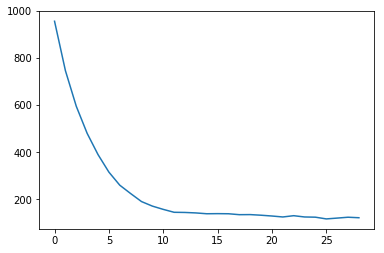

In [10]:
_ = pd.Series(history.history['loss']).plot()

In [11]:
train_pred = ann.predict(X_train).reshape(-1)

21161/21161 [==============================] - 0s 6us/step


In [12]:
train_err = mean_squared_error(y_train, train_pred)
train_err

97.64869722856795

In [13]:
train_df = pd.DataFrame([y_train, train_pred], index=['Truth', 'Predictions']).T

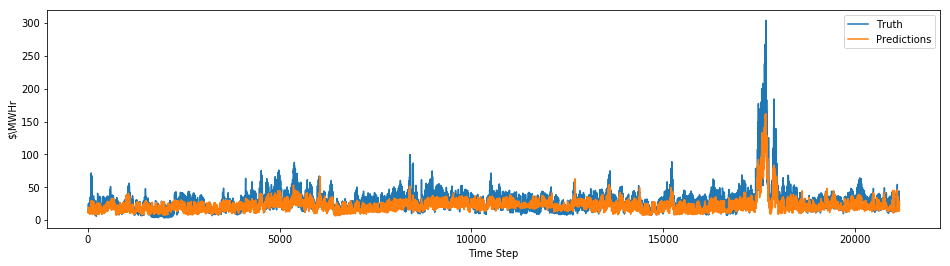

In [14]:
ax = train_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/ann-train.pdf')
plt.savefig('results/ann-train.svg')

## Testing

In [15]:
test = pd.read_csv('../feature_engineering/test.gz')
X_test = test[test.columns[:-1]].values
y_test = test[test.columns[-1]].values

In [16]:
test_pred = ann.predict(X_test).reshape(-1)

767/767 [==============================] - 0s 3us/step


In [17]:
test_err = mean_squared_error(y_test, test_pred)
test_err

80.06330923732705

In [18]:
test_df = pd.DataFrame([y_test, test_pred], index=['Truth', 'Predictions']).T

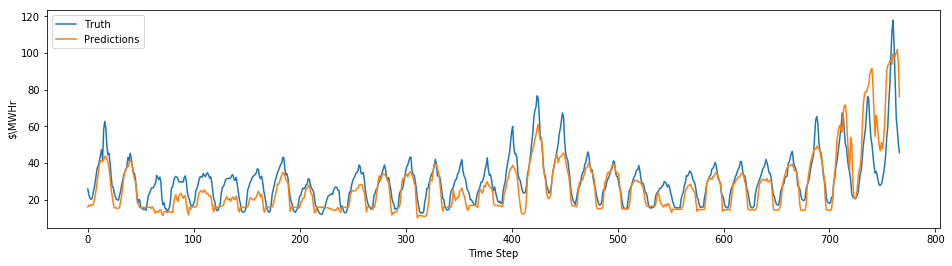

In [19]:
ax = test_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/ann-test.pdf')
plt.savefig('results/ann-test.svg')

## Results

In [20]:
results = pd.Series([train_err, test_err], index=['Train', 'Test'])
results

Train    97.648697
Test     80.063309
dtype: float64

In [21]:
results.to_csv('results/ann-mse.csv')